In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from collections import Counter
from prettytable import PrettyTable #For displaying output for question 4



In [2]:
'''brainstrorm:

    1. load edges and nodes.txt files
    2. remove isolated nodes
    3. make adjacency matrix
    4. find laplacian
    5. get eigenvectors/values with eigendecomp
    6. integrate eigenvectors with k means clustering algo
    7. analyze clusters... mismatch rate? majority label

'''
def calculate_cluster_statistics(cluster_id, cluster_labels, true_labels):
    '''
    This function calculates the majority labels and mismatch rates for a cluster
    '''
    
    #Find indices of nodes in the cluster
    cluster_indices = []
    for i in range(len(cluster_labels)):
        if cluster_labels[i] == cluster_id:
            cluster_indices.append(i)

    
    cluster_true_labels = []
    for i in cluster_indices:
        cluster_true_labels.append(true_labels[i])

    # Count occurrences of each label
    label_counts = Counter(cluster_true_labels)

    
    if len(label_counts) > 0:
        majority_label = max(label_counts, key=label_counts.get)
    else:
        majority_label = None

    
    mismatches = 0 # for loop to count mismatches
    for label in cluster_true_labels:
        if label != majority_label:
            mismatches += 1

    #calculate mismatch rate
    total_nodes = len(cluster_true_labels)
    if total_nodes > 0:
        mismatch_rate = mismatches / total_nodes
    else:
        mismatch_rate = 0

    return majority_label, mismatch_rate


def calculate_mismatch_rates(cluster_labels, true_labels, k):
    majority_labels = {}
    mismatch_rates = {}

    # Loop over each cluster and calculate statistics
    for cluster_id in range(k):
        majority_label, mismatch_rate = calculate_cluster_statistics(
            cluster_id, cluster_labels, true_labels
        )
        majority_labels[cluster_id] = majority_label
        mismatch_rates[cluster_id] = mismatch_rate

    # Calculate average mismatch rate
    if len(mismatch_rates) > 0:
        average_mismatch_rate = sum(mismatch_rates.values()) / len(mismatch_rates)
    else:
        average_mismatch_rate = 0

    #spread on mismatch rates
    if len(mismatch_rates) > 0:
        min_mismatch_rate = min(mismatch_rates.values())
        max_mismatch_rate = max(mismatch_rates.values())
        spread = max_mismatch_rate - min_mismatch_rate
    else:
        spread = 0

    return majority_labels, mismatch_rates, average_mismatch_rate, spread


In [4]:
#Attempting to remove all the isolated nodes from the data(nodes that are not connnected to any other nodes)

#Background info and sources:
#https://stackoverflow.com/questions/29464252/adjacency-matrix-in-python
#https://stackoverflow.com/questions/32381299/python-computing-vertex-degree-matrix/32383483 
#https://stackoverflow.com/questions/8092920/sort-eigenvalues-and-associated-eigenvectors-after-using-numpy-linalg-eig-in-pyt
#opening files

nodes = []
with open("data/nodes.txt", "r") as f:
    for line in f:
        stripped_line = line.strip()  
        node_data = stripped_line.split("\t")  
        nodes.append(node_data)  

# Read edges.txt
edges = []
with open("data/edges.txt", "r") as f:
    for line in f:
        stripped_line = line.strip()  
        edge_data = stripped_line.split("\t")  
        edges.append(edge_data)  


'''
For reference, nodes dataset information:
[,,,,]
node[0]:  Node ID that uniquely identifies the node in the graph. 
node[1]: Blog name like "100monkeystyping.com". Not used for connections.
node[2]: Label ( 0 or 1) – indicates the political orientation?
node[3]: Tags – metadata about the blog, not relaly important.
'''

connected_nodes = set()
#trying to store each noode ID only once
for edge in edges:
    connected_nodes.add(edge[0]) 
    connected_nodes.add(edge[1])  # Add end node

filtered_nodes = []

for node in nodes:
    # Check the first condition
    if node[0] in connected_nodes:
        filtered_nodes.append(node)
        
        
#creating adjacency matrix
node_to_index = {}
index_to_node = {}

for idx, node in enumerate(filtered_nodes):
    node_id = node[0]  
    node_to_index[node_id] = idx  # map Node ID to its index
    index_to_node[idx] = node_id  # Map index back to Node ID

n = len(filtered_nodes)
adjacency_matrix = []


for _ in range(n):  
    row = [0] * n  
    adjacency_matrix.append(row)  
for edge in edges:
    i = node_to_index[edge[0]]  #index of start node
    j = node_to_index[edge[1]]  #index of end node
    adjacency_matrix[i][j] = 1
    adjacency_matrix[j][i] = 1 
    

#Creating degree matrix
n = len(adjacency_matrix)
degree_matrix = []
for _ in range(n):
    row = [0] * n  # Create a row of zeros
    degree_matrix.append(row)
    
for i in range(n):
    degree = 0  
    for j in range(n):  
        connection = adjacency_matrix[i][j]
        degree = degree + connection
    degree_matrix[i][i] = degree  

    
D = np.array(degree_matrix)
A = np.array(adjacency_matrix)

# computing laplacian
L = D - A


#need to put into function
#https://pythonnumericalmethods.studentorg.berkeley.edu/notebooks/chapter15.04-Eigenvalues-and-Eigenvectors-in-Python.html
#Also used eigendecomposition from test_football.py demo code below

eigenvalues, eigenvectors = np.linalg.eigh(L)
sorted_indices = np.argsort(eigenvalues)  
eigenvalues = eigenvalues[sorted_indices]  
eigenvectors = eigenvectors[:, sorted_indices]


k_values = [2, 5, 10, 30, 50]
max_k = max(k_values)

#putting together feature matrix by pulling out specific eigenvectors for SC
feature_matrix = eigenvectors[:, 1:max_k+1]

true_labels = [] #extracting political orientations
for node in filtered_nodes:  
    true_labels.append(int(node[2]))


cluster_results = {}

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)  
    labels = kmeans.fit_predict(feature_matrix)  
    cluster_results[k] = labels 
    
    
#provides genral summary of the clustering performance utilize the functions written in previous cell
for k in k_values:
    if k in cluster_results:
        labels = cluster_results[k]
        majority_labels, mismatch_rates, avg_mismatch_rate, spread = calculate_mismatch_rates(
            labels, true_labels, k
        )

        #table format for valuesO
        print(f"Results for k = {k}")
        table = PrettyTable()
        table.field_names = ["Cluster", "Majority Label", "Mismatch Rate"]
        
        for cluster_id in range(k):
            majority_label = majority_labels.get(cluster_id, "N/A")
            mismatch_rate = mismatch_rates.get(cluster_id, 0.0)
            table.add_row([cluster_id, majority_label, f"{mismatch_rate:.4f}"])
        
        print(table)
        print(f"Average Mismatch Rate = {avg_mismatch_rate:.5f}")
        print(f"Spread of Mismatch Rates = {spread:.4f}")

Results for k = 2
+---------+----------------+---------------+
| Cluster | Majority Label | Mismatch Rate |
+---------+----------------+---------------+
|    0    |       1        |     0.4800    |
|    1    |       0        |     0.0000    |
+---------+----------------+---------------+
Average Mismatch Rate = 0.23998
Spread of Mismatch Rates = 0.4800
Results for k = 5
+---------+----------------+---------------+
| Cluster | Majority Label | Mismatch Rate |
+---------+----------------+---------------+
|    0    |       1        |     0.4803    |
|    1    |       0        |     0.0000    |
|    2    |       1        |     0.0000    |
|    3    |       1        |     0.0000    |
|    4    |       0        |     0.0000    |
+---------+----------------+---------------+
Average Mismatch Rate = 0.09607
Spread of Mismatch Rates = 0.4803
Results for k = 10
+---------+----------------+---------------+
| Cluster | Majority Label | Mismatch Rate |
+---------+----------------+---------------+
|  

Optimal k: 18
Minimum Average Mismatch Rate: 0.02639


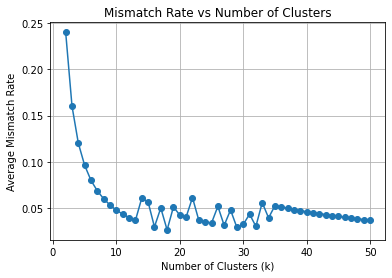

In [5]:

optimal_k = None
min_mismatch_rate = float('inf')
k_values = range(2, 51)  
mismatch_rates = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    labels = kmeans.fit_predict(feature_matrix)
    majority_labels, mismatch_rate_dict, avg_mismatch_rate, spread = calculate_mismatch_rates(
        labels, true_labels, k
    )
    mismatch_rates.append(avg_mismatch_rate)
    #using previous code snippet from last question 
    if avg_mismatch_rate < min_mismatch_rate:
        min_mismatch_rate = avg_mismatch_rate
        optimal_k = k


print(f"Optimal k: {optimal_k}")
print(f"Minimum Average Mismatch Rate: {min_mismatch_rate:.5f}")

import matplotlib.pyplot as plt
plt.plot(k_values, mismatch_rates, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Mismatch Rate')
plt.title('Mismatch Rate vs Number of Clusters')
plt.grid()
plt.show()